In [68]:
import micasense.imageset as imageset
import micasense.capture as capture
import cv2
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils
import os, glob
import json
import tqdm
import pickle #This library will maintain the format as well
import importlib
import radiometric_calib_utils
import mutils
import extract_spectral
importlib.reload(radiometric_calib_utils)
importlib.reload(mutils)
importlib.reload(extract_spectral)
import radiometric_calib_utils as rcu
import mutils
import extract_spectral as espect
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from math import ceil

# Plot bboxes

In [2]:
with open(r"saved_bboxes\10thSur24Aug_F1_RawImg_IMG_0005_1.txt", 'r') as fp:
    data = json.load(fp)
data

{'F:/surveys_10band/10thSur24Aug/F1/RawImg\\IMG_0005_1.tif': {'turbid_glint': [[22,
    695],
   [102, 826]],
  'water_glint': [[85, 519], [170, 593]],
  'turbid': [[896, 468], [990, 531]],
  'water': [[544, 184], [709, 298]],
  'shore': [[683, 684], [831, 741]]}}

In [23]:
wavelengths = mutils.sort_bands_by_wavelength()
wavelengths_idx = np.array([i[0] for i in wavelengths])
wavelengths_idx

array([5, 0, 6, 1, 7, 2, 8, 4, 9, 3])

In [89]:
class ExtractSpectral:
    def __init__(self,dir):
        """ 
        :param dir (str): directory of where all the bboxes (.txt) are stored i.e. saved_bboxes/
        """
        self.dir = dir
        # initialise categories
        self.button_names = ['turbid_glint','water_glint','turbid','water','shore']
        # intialise colours
        self.colors = ['orange','cyan','saddlebrown','blue','yellow']
        self.color_mapping = {categories:colors for categories,colors in zip(self.button_names,self.colors)}
        # import wavelengths for each band
        wavelengths = mutils.sort_bands_by_wavelength()
        self.n_bands = len(wavelengths)
        self.wavelengths_idx = np.array([i[0] for i in wavelengths])
        self.wavelengths = np.array([i[1] for i in wavelengths])
        # aligning band images
        self.warp_mode = cv2.MOTION_HOMOGRAPHY
        self.img_type = "reflectance"
    def store_bboxes(self):
        """ 
        get all the bboxes txt files are store the info in a dictionary with keys:
        parent_directory (e.g. 'F:/surveys_10band/10thSur24Aug/F1/RawImg')
            img_names (e.g. 'IMG_0004_1.tif')
        """
        fp_list = [os.path.join(self.dir,fp) for fp in os.listdir(self.dir)]
        store_dict = dict()
        for fp in fp_list:
            with open(fp, 'r') as fp:
                data = json.load(fp)
            basename,file_name = os.path.split(list(data)[0])
            store_dict[basename] = dict()
        
        for fp in fp_list:
            with open(fp, 'r') as fp:
                data = json.load(fp)
            basename,file_name = os.path.split(list(data)[0])
            bboxes = {k: v for d in data.values() for k,v in d.items() if v is not None}
            if bool(bboxes) is True:
                store_dict[basename][file_name] = bboxes
                # store_dict[basename] = {file_name: bboxes}
            
        return store_dict

    def get_warp_matrices(self,current_fp):
        """ 
        from current_fp, import captures and output warp_matrices and cropped_dimensions
        """
        cap = mutils.import_captures(current_fp)
        warp_matrices = cap.get_warp_matrices()
        cropped_dimensions,edges = imageutils.find_crop_bounds(cap,warp_matrices)
        return warp_matrices, cropped_dimensions

    def plot_bboxes(self,show_n = 6,figsize=(8,20)):
        """ 
        :param dir (str): directory of where all the bboxes (.txt) are stored i.e. saved_bboxes/
        :param show_n (int): show how many plots. if number of images exceeds show_n, plot only show_n
        """
        store_dict = self.store_bboxes()

        for flight_fp, img_dict in store_dict.items():
            images_names = list(img_dict)
            n_images = len(images_names)
            if n_images > 0:
                current_fp = os.path.join(flight_fp,images_names[0])
                warp_matrices, cropped_dimensions = self.get_warp_matrices(current_fp)

                if n_images < show_n:
                    fig, axes = plt.subplots(ceil(n_images/2),2,figsize=figsize)
                else:
                    fig, axes = plt.subplots(ceil(show_n/2),2,figsize=figsize)
                    img_dict = {i:img_dict[i] for i in list(images_names)[:show_n]}
                
                for (image_name,bboxes),ax in zip(img_dict.items(),axes.flatten()):
                    current_fp = os.path.join(flight_fp,image_name)
                    cap = mutils.import_captures(current_fp)
                    rgb_image = mutils.aligned_capture_rgb(cap, warp_matrices, cropped_dimensions)
                    ax.imshow(rgb_image)
                    ax.set_title(image_name)
                    ax.axis('off')
                    for categories, bbox in bboxes.items():
                        coord, w, h = mutils.bboxes_to_patches(bbox)
                        rect = patches.Rectangle(coord, w, h, linewidth=1, edgecolor=self.color_mapping[categories], facecolor='none')
                        patch = ax.add_patch(rect)
                fig.suptitle(flight_fp)
                plt.show()
    
    def get_multispectral_bboxes(self,parent_dir,img_fp,img_bboxes=None,warp_matrices=None, cropped_dimensions=None):
        """ 
        :param parent_dir (str): folder which contains raw images (keys of store_bboxes()) e.g. F:/surveys_10band/10thSur24Aug/F1/RawImg
        :param img_fp (str): image name e.g. 'IMG_0004_1.tif'
        :param img_bboxes (dict): keys are categories e.g. turbid_glint, turbid, water_glint, water and shore, and values are the corresponding bboxes
        :param warp_matrices (list of arrays): to align band images
        :param cropped_dimensions (tuple): to cropp images for band images alignment
        returns multispectral reflectance (im_aligned), and bboxes of categories
        """
        warp_mode = cv2.MOTION_HOMOGRAPHY
        img_type = "reflectance"
        fp = os.path.join(parent_dir,img_fp)
        cap = mutils.import_captures(fp)
        if warp_matrices is None and cropped_dimensions is None:
            warp_matrices = cap.get_warp_matrices()
            cropped_dimensions,_ = imageutils.find_crop_bounds(cap,warp_matrices)
        im_aligned = imageutils.aligned_capture(cap, warp_matrices, warp_mode, cropped_dimensions, None, img_type=img_type)
        if img_bboxes is None:
            img_bboxes = self.store_bboxes()
        bboxes = img_bboxes[parent_dir][img_fp]
        return im_aligned, bboxes

    def plot_multispectral(self,parent_dir,img_fp,img_bboxes=None,warp_matrices=None, cropped_dimensions=None):
        """ 
        :param parent_dir (str): folder which contains raw images (keys of store_bboxes()) e.g. F:/surveys_10band/10thSur24Aug/F1/RawImg
        :param img_fp (str): image name e.g. 'IMG_0004_1.tif'
        :param img_bboxes (dict): keys are categories e.g. turbid_glint, turbid, water_glint, water and shore, and values are the corresponding bboxes
        :param warp_matrices (list of arrays): to align band images
        :param cropped_dimensions (tuple): to cropp images for band images alignment
        returns a plot of the rgb_image, drawn bboxes, and spectral reflectance
        """
        im_aligned, bboxes = self.get_multispectral_bboxes(parent_dir,img_fp,img_bboxes,warp_matrices, cropped_dimensions)
        
        n_cats = len(list(bboxes)) # number of categories based on bboxes drawn

        # initialise plot
        fig = plt.figure(figsize=(6, 2*(1+n_cats)), layout="constrained")
        spec = fig.add_gridspec(1+n_cats, 2) #first row is for the image
        # plot rgb
        rgb_image = mutils.get_rgb(im_aligned,plot=False)
        ax0 = fig.add_subplot(spec[0, :])
        ax0.imshow(rgb_image)
        ax0.set_title('Image')
        ax0.set_axis_off()

        for i, (category,bbox) in enumerate(bboxes.items()):
            ((x1,y1),(x2,y2)) = bbox
            if x1 > x2:
                x1, x2 = x2, x1
            if y1 > y2:
                y1,y2 = y2, y1

            ax_idx = i+1 #axis index
            ax_im = fig.add_subplot(spec[ax_idx, 0]) # axis for adding cropped image based on bbox
            ax_line = fig.add_subplot(spec[ax_idx, 1]) # axis for adding spectral reflectances
            
            # crop rgb image based on bboxes drawn
            im_cropped = rgb_image[y1:y2,x1:x2,:]
            # get multispectral reflectances from bboxes
            spectral_flatten = im_aligned[y1:y2,x1:x2,:].reshape(-1,im_aligned.shape[-1])
            wavelength_flatten = spectral_flatten[:,self.wavelengths_idx]
            wavelength_mean = np.mean(wavelength_flatten,axis=0)
            wavelength_var = np.sqrt(np.var(wavelength_flatten,axis=0)) #std dev
            
            # add patches to plots
            coord, w, h = mutils.bboxes_to_patches(bbox)
            c = self.color_mapping[category]
            rect = patches.Rectangle(coord, w, h, linewidth=1, edgecolor=c, facecolor='none')
            patch = ax0.add_patch(rect)
            
            ax_im.imshow(im_cropped)
            ax_im.set_title(category)
            ax_im.set_axis_off()
            ax_line.plot(self.wavelengths,wavelength_mean,color=c)
            eb = ax_line.errorbar(self.wavelengths,wavelength_mean,yerr=wavelength_var,color=c)
            eb[-1][0].set_linestyle('--')
            ax_line.set_title(f'Spectra ({category})')
            ax_line.set_xlabel('Wavelength (nm)')
            ax_line.set_ylabel('Reflectance (%)')
        
        plt.show()
        
        return
    

ES = ExtractSpectral(r"saved_bboxes")
img_bboxes = ES.store_bboxes()
img_bboxes
# ES.plot_bboxes(figsize=(10,5))

{'F:/surveys_10band/10thSur24Aug/F1/RawImg': {'IMG_0004_1.tif': {'turbid_glint': [[8,
     369],
    [153, 491]],
   'water_glint': [[48, 184], [110, 343]],
   'turbid': [[834, 343], [930, 406]],
   'water': [[979, 88], [1078, 193]],
   'shore': [[473, 494], [595, 587]]},
  'IMG_0005_1.tif': {'turbid_glint': [[22, 695], [102, 826]],
   'water_glint': [[85, 519], [170, 593]],
   'turbid': [[896, 468], [990, 531]],
   'water': [[544, 184], [709, 298]],
   'shore': [[683, 684], [831, 741]]}},
 'F:/surveys_10band/1stSur6Apr/F1/RawImg': {},
 'F:/surveys_10band/2ndSur28Apr/F1/RawImg': {}}

In [91]:
warp_mode = cv2.MOTION_HOMOGRAPHY
img_type = "reflectance"
parent_dir = list(img_bboxes)[0]
img_fp = 'IMG_0004_1.tif'
fp = os.path.join(parent_dir,img_fp)
print(fp)
cap = mutils.import_captures(fp)
warp_matrices = cap.get_warp_matrices()
cropped_dimensions,_ = imageutils.find_crop_bounds(cap,warp_matrices)
im_aligned = imageutils.aligned_capture(cap, warp_matrices, warp_mode, cropped_dimensions, None, img_type=img_type)
bboxes = img_bboxes[parent_dir][img_fp]
# for category, bbox in bboxes:
bboxes_i = bboxes['water_glint']
bboxes

F:/surveys_10band/10thSur24Aug/F1/RawImg\IMG_0004_1.tif


{'turbid_glint': [[8, 369], [153, 491]],
 'water_glint': [[48, 184], [110, 343]],
 'turbid': [[834, 343], [930, 406]],
 'water': [[979, 88], [1078, 193]],
 'shore': [[473, 494], [595, 587]]}

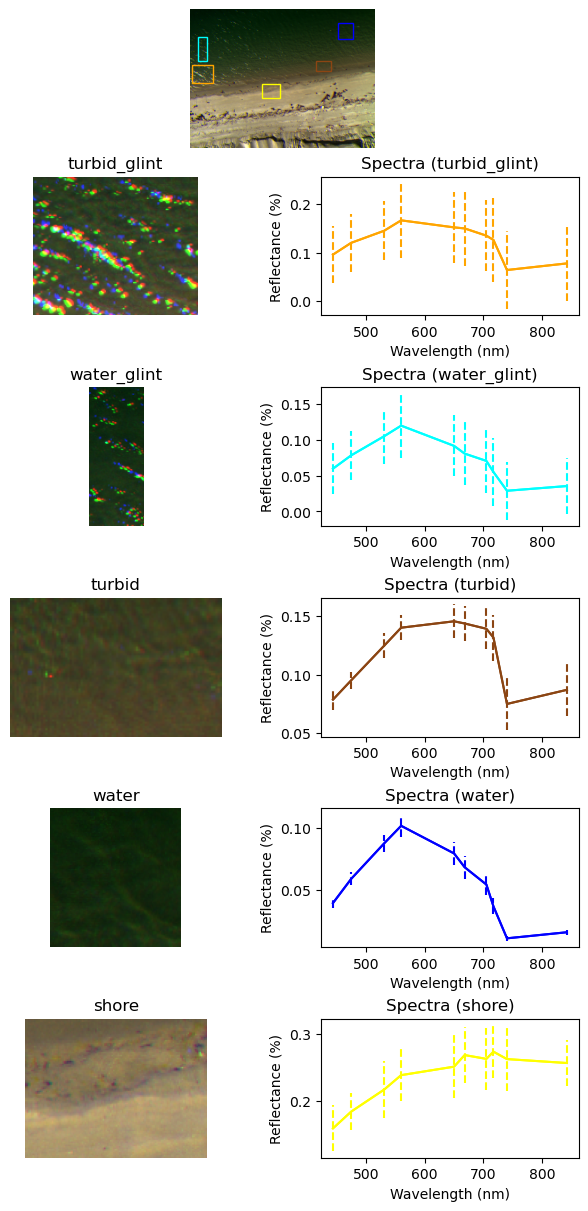

In [88]:
ES = ExtractSpectral(r"saved_bboxes")
ES.plot_multispectral(parent_dir,img_fp,img_bboxes=img_bboxes,warp_matrices=warp_matrices, cropped_dimensions=cropped_dimensions)

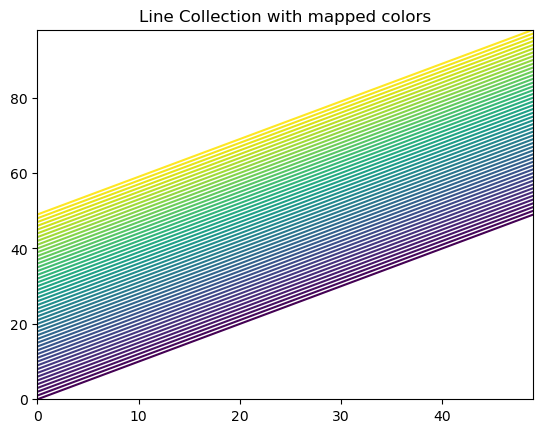

In [100]:
from matplotlib.collections import LineCollection
N = 50
x = np.arange(N)
# print(x)
ys = [x + i for i in x]  # Many sets of y to plot vs. x
# print(ys[1])
segs = [np.column_stack([x, y]) for y in ys] 
# list of arrays (lines), where each array (line) represents the x,y coordinates (n,2)

fig, ax = plt.subplots()
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys), np.max(ys))

line_segments = LineCollection(segs, array=x,
                               #linewidths=(0.5, 1, 1.5, 2),
                               linestyles='solid')
ax.add_collection(line_segments)
# axcb = fig.colorbar(line_segments)
# axcb.set_label('Line Number')
ax.set_title('Line Collection with mapped colors')
# plt.sci(line_segments)  # This allows interactive changing of the colormap.
plt.show()

In [ ]:
def plot_TSS_conc_image(df):
    """ 
    input is a df with last 61 columns as wavelengths and a column called 'Concentration' that corresponds to TSS concentration
    unit (str): label for the colour map e.g. FNU or mg/l
    outputs individual reflectance curve mapped to TSS concentration
    """
    def multiline(xs, ys, c, ax=None, **kwargs):
        """Plot lines with different colorings

        Parameters
        ----------
        xs : iterable container of x coordinates
        ys : iterable container of y coordinates
        c : iterable container of numbers mapped to colormap
        ax (optional): Axes to plot on.
        kwargs (optional): passed to LineCollection

        Notes:
            len(xs) == len(ys) == len(c) is the number of line segments
            len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

        Returns
        -------
        lc : LineCollection instance.
        """

        # find axes
        ax = plt.gca() if ax is None else ax

        # create LineCollection
        segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
        lc = LineCollection(segments, **kwargs)

        # set coloring of line segments
        #    Note: I get an error if I pass c as a list here... not sure why.
        lc.set_array(np.asarray(c))

        # add lines to axes and rescale 
        #    Note: adding a collection doesn't autoscalee xlim/ylim
        ax.add_collection(lc)
        ax.autoscale()
        return lc

    

    ncols = len(df.columns)
    col_names = df.columns.tolist()
    columns = ['Concentration'] + col_names[-61:]
    df_plot = df.loc[:,columns].set_index('Concentration')
    wavelength = df_plot.columns.tolist()

    concentration = df_plot.index.tolist()
    n_lines = len(concentration)
    y_array = df_plot.reset_index().iloc[:,-61:].values #reflectance
    x_array = np.array([wavelength for i in range(n_lines)])

    fig, ax = plt.subplots(figsize=(6,6))
    lc = multiline(x_array, y_array, concentration, cmap='BrBG_r', lw=1)
    ax.set_ylim(0,40)
    ax.set_xlim(450,950)
    
    axcb = fig.colorbar(lc)
    axcb.set_label('Concentration')
    ax.set_title('Reflectance of water quality variable')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Reflectance (%)')
    plt.rcParams["font.size"] = "8"
    return fig

In [4]:
x = np.linspace(1,9,9).reshape(3,3,1)
x = np.repeat(x,3,axis=2)
# X = x[1:3,0:2,:]
X = x.reshape(-1,3)
X[:,0]

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [47]:
x = np.ones((3,3,3))
x = np.multiply(x,np.array([1,2,3]))
X = x[:,:,np.array([2,1,0])]
np.mean(X,axis=(0,1))
np.var(X,axis=(0,1))

array([0., 0., 0.])

In [14]:
indices = np.linspace(0,8,9,dtype=int)
indices
y,x = np.unravel_index(indices,(3,3))
y

array([0, 0, 0, 1, 1, 1, 2, 2, 2], dtype=int64)